# CS4035 - Cyber Data Analytics
## Lab 1 - Fraud data

### Submit on brightspace (zip file with the name Group_xx.zip)

In [34]:
# If this cell does not work try running `pip install nbformat`

import io
from IPython import nbformat

nb = nbformat.read("Lab1-2021_RANKSWAP_Andrew_Gold.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 746


In [35]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib as plt
from collections import Counter
import matplotlib.pyplot as plt
import bisect
import random
import re

from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import plot_roc_curve, precision_recall_fscore_support, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE # I used this library, as Srinath was not able to finish his SMOTE implementation until 20 minutes before the deadline.

import shap
import datetime as dt
import time
import pytz

In [5]:
# data is pickled, faster than a CSV
df = pd.read_pickle("~/Documents/Delft/CDA 2021/Lab 1/data_lab_1.pkl")
df

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290377,482729,2015-11-03 18:57:01,SE,visadebit,453903.0,48100.0,SEK,SE,Ecommerce,Settled,True,1,2015-10-31 23:21:58,SwedenAccount,email135821,ip125573,card83162
290378,482731,2015-11-03 08:12:14,SE,mcdebit,554501.0,195000.0,SEK,SE,Ecommerce,Settled,True,1,2015-10-31 23:31:24,SwedenAccount,email259702,ip202029,card131519
290379,482732,2015-11-03 08:12:14,SE,visadebit,453903.0,52500.0,SEK,SE,Ecommerce,Settled,True,1,2015-10-31 23:41:40,SwedenAccount,email32927,ip229869,card142173
290380,482733,2015-11-03 18:56:44,SE,mcdebit,554501.0,87700.0,SEK,SE,Ecommerce,Settled,True,1,2015-10-31 23:50:07,SwedenAccount,email97400,ip200721,card141579


In [6]:
# simple_journal seems to be the attribute that includes transaction type. How many chargebacks (fraud) exist in the set?
print(len(df.simple_journal[df.simple_journal == 'Chargeback']))
print('Total ratio of chargebacks to total transactions: ' + str(len(df.simple_journal[df.simple_journal == 'Chargeback']) / len(df.index)))
print('Total ratio of refused transactions to total transactions: ' + str(len(df.simple_journal[df.simple_journal == 'Refused']) / len(df.index)))
print('Total ratio of legitimate transactions to total transactions: ' + str(len(df.simple_journal[df.simple_journal == 'Settled']) / len(df.index)))

345
Total ratio of chargebacks to total transactions: 0.0011880901708783602
Total ratio of refused transactions to total transactions: 0.1837097340744261
Total ratio of legitimate transactions to total transactions: 0.8151021757546956


## Group Number: 69

## Student 1 
### Name: Andrew Gold
### ID: 4995902

## Readme instructions:

Install the following packages:

`pip3 install imblearn` for over/undersampling (to compare their SMOTE implementation with ours)

`pip3 install shap` for classifier interpretation in section 4


In [7]:
# I took the previous block and changed it to an md format. It is a lot more readable IMO - Srinath 
# Attribute List:
# issuercountrycode: country where the card was issued
# txvariantcode: the card type that was used (subbrand of visa or master card)
# bin: card issuer identifier
# amount/currencycode: transaction amount in minor units (so 100 EUR = 100 euro cent)
# shoppercountrycode: IP address country
# shopperinteraction: Ecommerce if it was an online transaction, ContAuth if it was a (monthly) subscription, POS if the card was used at Point of Sale
# simple_journal: Payment status. Authorised = “transaction approved and no fraud reported”, Refused = “transaction was declined, can be fraud, but can also be insufficient funds, etc”, Chargeback = “transaction was approved, but turned out to be fraud”
# bookingdate: only relevant for Chargebacks. Time stamp when the chargeback was reported. During simulation you may only use this knowledge after this date. So for example if on an email address a transaction ended in a chargeback, you can only block that email address after the booking date of the chargeback.
# cardverificationresponsesupplied: did the shopper provide his 3 digit CVC/CVV2 code?
# cvcresponsecode: Validation result of the CVC/CVV2 code: 0 = Unknown, 1=Match, 2=No Match, 3-6=Not checked
# creationdate: Date of transaction
# accountcode: merchant’s webshop
# mail_id: Email address
# ip_id: Ip address
# card_id: Card number

In [8]:
###  First let's process the data for a bit more easier visualization
# We can one-hot encode all the string variables and then keep a table for reference - useful for ML
# For the dates, we can either sort the dataframe by the dates sequentially and then drop the column or convert to UNIX time

In [9]:
# Let's see how many null items exist in our dataset
df.isnull().sum()

txid                                0
bookingdate                         0
issuercountrycode                 493
txvariantcode                       0
bin                               140
amount                              0
currencycode                        0
shoppercountrycode                482
shopperinteraction                  0
simple_journal                      0
cardverificationcodesupplied    14717
cvcresponsecode                     0
creationdate                        0
accountcode                         0
mail_id                             0
ip_id                               0
card_id                             0
dtype: int64

In [10]:
# Manually fix each of these

# Create a fake country
df.issuercountrycode.iloc[np.where(df.issuercountrycode.isnull())] = 'ZZZ'

# Create a fake bin
df.bin.iloc[np.where(df.bin.isnull())] = 0

# Create a fake country code
df.shoppercountrycode.iloc[np.where(df.shoppercountrycode.isnull())] = 'ZZZ'

# Force all null values in "cardverificationcodesupplied" to "False"
df.cardverificationcodesupplied.iloc[np.where(df.cardverificationcodesupplied.isnull())] = False



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
### ENCODE STRING VARIABLES ###


label_encoder = LabelEncoder() # for encoding target labels
# ordinal_encoder = OrdinalEncoder() # for encoding features with 
# OH_encoder = OneHotEncoder()


# issuercountrycode - encode
df.issuercountrycode = label_encoder.fit_transform(df.issuercountrycode)


# txvariantcode
df.txvariantcode = label_encoder.fit_transform(df.txvariantcode)


# currencycode 
df.currencycode = label_encoder.fit_transform(df.currencycode)


# shoppercountrycode
df.shoppercountrycode = label_encoder.fit_transform(df.shoppercountrycode)


# shopperinteraction
df.shopperinteraction = label_encoder.fit_transform(df.shopperinteraction)


# bin
df.bin = label_encoder.fit_transform(df.bin)


# simple_journal (Chargeback = 0 (fraud), Rejected = 1 (possible fraud), Settled = 2)
df.simple_journal = label_encoder.fit_transform(df.simple_journal)


# cardverificationcodesupplied
df.cardverificationcodesupplied = label_encoder.fit_transform(df.cardverificationcodesupplied)


# accountcode
df.accountcode = label_encoder.fit_transform(df.accountcode)


# mail_id
df.mail_id = label_encoder.fit_transform(df.mail_id)


# ip_id
df.ip_id = label_encoder.fit_transform(df.ip_id)


# card_id
df.card_id = label_encoder.fit_transform(df.card_id)


df.bookingdate = pd.to_datetime(df.bookingdate).astype('int64')
df.creationdate = pd.to_datetime(df.creationdate).astype('int64')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290382 entries, 0 to 290381
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   txid                          290382 non-null  int64  
 1   bookingdate                   290382 non-null  int64  
 2   issuercountrycode             290382 non-null  int32  
 3   txvariantcode                 290382 non-null  int32  
 4   bin                           290382 non-null  int64  
 5   amount                        290382 non-null  float64
 6   currencycode                  290382 non-null  int32  
 7   shoppercountrycode            290382 non-null  int32  
 8   shopperinteraction            290382 non-null  int32  
 9   simple_journal                290382 non-null  int32  
 10  cardverificationcodesupplied  290382 non-null  int32  
 11  cvcresponsecode               290382 non-null  int64  
 12  creationdate                  290382 non-nul

In [12]:
# Fixed?
df.isnull().sum()

txid                            0
bookingdate                     0
issuercountrycode               0
txvariantcode                   0
bin                             0
amount                          0
currencycode                    0
shoppercountrycode              0
shopperinteraction              0
simple_journal                  0
cardverificationcodesupplied    0
cvcresponsecode                 0
creationdate                    0
accountcode                     0
mail_id                         0
ip_id                           0
card_id                         0
dtype: int64

In [13]:
# Data is encoded, nothing but int/float variables
df.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,1447079211000000000,92,3,3204,64800.0,2,103,1,0,1,0,1435791791000000000,1,198681,8033,81635
1,2,1447079258000000000,92,3,3749,44900.0,2,103,1,0,1,0,1435812655000000000,1,921,205937,49763
2,3,1448296456000000000,92,3,3159,149900.0,2,103,1,0,1,0,1435847428000000000,1,126264,200422,136762
3,4,1448296491000000000,92,3,3762,109900.0,2,103,1,0,1,0,1435910017000000000,1,183709,9264,78697
4,5,1447079168000000000,92,7,2115,89900.0,2,103,1,0,1,0,1436380535000000000,1,74828,209046,232186


## 3. Privacy task (Rank Swap) – 1 A4 – Individual

In [14]:
### --- Define df_X and df_Y to be unified across the notebook --- ###

df_X = df.drop('simple_journal', axis=1, inplace=False)
df_X.drop('bookingdate', axis=1, inplace=True) # Drop timestamp to prevent potential overfitting
df_X.drop('txid', axis=1, inplace=True) # Chargebacks are grouped by txid

df_Y = df.simple_journal

# Transform into a binary problem by combining "benign" and "potentially fraud" to reduce false positives

df_Y.loc[np.where(df_Y == 2)] = 1 # Combine the benign and "maybe fraud" values
df_Y.loc[np.where(df_Y == 0)] = 3 # Set the fraud values to 3 temporarily
df_Y.loc[np.where(df_Y == 1)] = 0 # Set the benign values = 0
df_Y.loc[np.where(df_Y == 3)] = 1 # Set the fraud target value = 1

df_X = pd.DataFrame(StandardScaler().fit_transform(df_X), columns=df_X.columns)

### --- Define the training and test datasets --- ###

# Unshuffled data (since the timing of transactions might affect outcome)
x_train, x_test, y_train, y_test = train_test_split(df_X, df_Y, shuffle=False, test_size = 0.2)

# Shuffled data (to contrast the unshuffled data)
x_train_shuf, x_test_shuf, y_train_shuf, y_test_shuf = train_test_split(df_X, df_Y, shuffle=True, test_size = 0.2)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
# Implement rank swap algorithm
def rank_swap(data, p):
    # P is the rank range as a percentage of total size, so if P = 0.01 then the range is 1%
    assert(p > 0 and p <= 1.0) # assert that p must be between 0.0 and 1.0
    
    original = data.to_numpy() # Convert to array format
    attributes_original = [] # Save the original
    attributes_ordered = [] # Save the ordered attributes

    
    for attribute_index in range(len(original[0])):

        attribute_values_original = [item[attribute_index] for item in original]
        attributes_original.append(attribute_values_original)

        attribute_values_ordered = (attribute_values_original.copy())
        attribute_values_ordered.sort()
        attributes_ordered.append(attribute_values_ordered)

    rank_swapped_data = original.copy()

    margin = round((p * len(original)))
    len_original = len(original)-1

    for row_index, row in enumerate(original):
        for attribute_index, attribute_value in enumerate(row):
            ordered_item_index = bisect.bisect_left(attributes_ordered[attribute_index], attribute_value)

            possible_swap_indices_lower = max(0, ordered_item_index - margin)
            possible_swap_indices_upper = min(len_original, ordered_item_index + margin)

            selected_swap_index = random.randint(possible_swap_indices_lower, possible_swap_indices_upper)
              
            selected_swap_value = original[selected_swap_index][attribute_index]

            rank_swapped_data[selected_swap_index][attribute_index] = rank_swapped_data[row_index][attribute_index]

            rank_swapped_data[row_index][attribute_index] = selected_swap_value
    return rank_swapped_data

In [16]:
### Define the datasets:
# df_swapped: dataset that has been rank-swapped
# df_unswapped: dataset that has not been rank-swapped
# df_smote_swapped: dataset that has been SMOTE and rank-swapped





x_train_swap = pd.DataFrame(rank_swap(x_train, 0.1), columns = x_train.columns)
x_train_smote_swap, y_train_smote_swap = SMOTE(0.5).fit_resample(x_train_swap, y_train)
x_train_smote, y_train_smote = SMOTE(0.5).fit_resample(x_train, y_train)


print(x_train.shape, y_train.shape)
print(x_train_swap.shape, y_train.shape)
print(x_train_smote_swap.shape, y_train_smote_swap.shape)
print(x_train_smote.shape, y_train_smote.shape)

Pass sampling_strategy=0.5 as keyword args. From version 0.9 passing these as positional arguments will result in an error
Pass sampling_strategy=0.5 as keyword args. From version 0.9 passing these as positional arguments will result in an error


(232305, 14) (232305,)
(232305, 14) (232305,)
(347985, 14) (347985,)
(347985, 14) (347985,)


In [26]:
### --- Create 3 classification models --- ###
# SGD logistic classifier

# Logistic classifier, Hinge instead of Ridge due to the complexity of the data and low correlation between most features, no shuffling (time may be a factor)
SGD_swap = SGDClassifier(loss='hinge', penalty='l1', shuffle=False, n_jobs=-1, max_iter=1000)
SGD_unswap = SGDClassifier(loss='hinge', penalty='l1', shuffle=False, n_jobs=-1, max_iter=1000)
SGD_smote_swap = SGDClassifier(loss='hinge', penalty='l1', shuffle=False, n_jobs=-1, max_iter=1000)
SGD_smote_unswap = SGDClassifier(loss='hinge', penalty='l1', shuffle=False, n_jobs=-1, max_iter=1000)


%time SGD_unswap.fit(x_train, y_train)
%time SGD_swap.fit(x_train_swap, y_train)
%time SGD_smote_swap.fit(x_train_smote_swap, y_train_smote_swap)
%time SGD_smote_unswap.fit(x_train_smote, y_train_smote)

Wall time: 206 ms
Wall time: 157 ms
Wall time: 260 ms
Wall time: 231 ms


SGDClassifier(n_jobs=-1, penalty='l1', shuffle=False)

In [18]:
# print("Swapped data score: ", SGD_swap.score(x_test, y_test))
# print("Unswapped data score: ", SGD_unswap.score(x_test, y_test))
# print("Swapped SMOTE data score: ", SGD_smote_swap.score(x_test, y_test))

In [19]:
knn_swap = KNeighborsClassifier(n_neighbors=10)
knn_unswap = KNeighborsClassifier(n_neighbors=10)
knn_smote_swap = KNeighborsClassifier(n_neighbors=10)
knn_smote_unswap = KNeighborsClassifier(n_neighbors=10)

%time knn_unswap.fit(x_train, y_train)
%time knn_swap.fit(x_train_swap, y_train)
%time knn_smote_swap.fit(x_train_smote_swap, y_train_smote_swap)
%time knn_smote_unswap.fit(x_train_smote, y_train_smote)

# print("Unswapped KNN Score: ", knn_unswap.score(x_test, y_test))
# print("Swapped KNN Score: ", knn_swap.score(x_test, y_test))
# print("Swapped SMOTE KNN Score: ", knn_smote_swap.score(x_test, y_test))

Wall time: 1min 12s
Wall time: 1min 30s
Wall time: 3min 24s
Wall time: 3min 13s


KNeighborsClassifier(n_neighbors=10)

In [20]:
forest_swap = RandomForestClassifier(n_estimators=1000)
forest_unswap = RandomForestClassifier(n_estimators=1000)
forest_smote_swap = RandomForestClassifier(n_estimators=1000)
forest_smote_unswap = RandomForestClassifier(n_estimators=1000)

%time forest_unswap.fit(x_train, y_train)
%time forest_swap.fit(x_train_swap, y_train)
%time forest_smote_swap.fit(x_train_smote_swap, y_train_smote_swap)
%time forest_smote_unswap.fit(x_train_smote, y_train_smote)

Wall time: 4min 13s
Wall time: 5min 29s
Wall time: 12min 2s
Wall time: 11min 59s


RandomForestClassifier(n_estimators=1000)

In [31]:
# print("Random forest with unswapped data score: ", forest_unswap.score(x_test, y_test))
# print("Random forest with swapped data score: ", forest_swap.score(x_test, y_test))
# print("Random forest with swapped SMOTE data: ", forest_smote_swap.score(x_test, y_test))
# print("Random forest with unswapped SMOTE data: ", forest_smote_swap.score(x_test, y_test))

### 3a. Print ROC curves

Wall time: 28 ms
Wall time: 15 ms
Wall time: 14 ms
Wall time: 19 ms


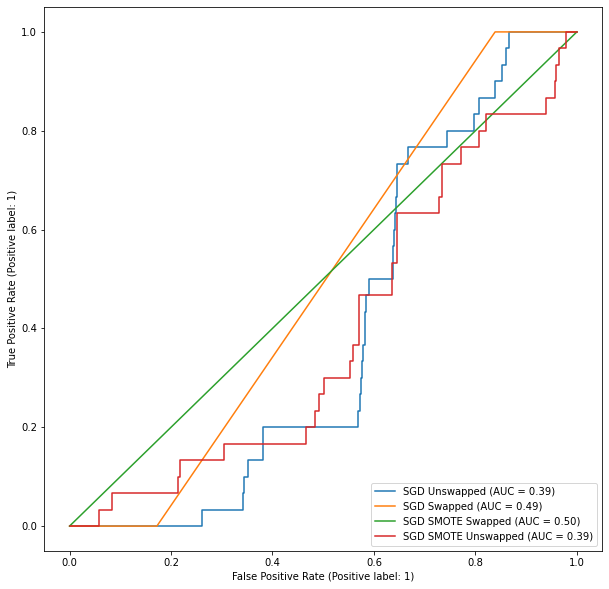

Wall time: 274 ms


In [21]:
fig, (ax1) = plt.subplots(1,figsize=(10,10))

%time SGD_unswap_roc = plot_roc_curve(SGD_unswap, x_test, y_test, ax=ax1, name="SGD Unswapped")
%time SGD_swap_roc = plot_roc_curve(SGD_swap, x_test, y_test, ax=ax1, name="SGD Swapped")
%time SGD_smote_swap_roc = plot_roc_curve(SGD_smote_swap, x_test, y_test, ax=ax1, name="SGD SMOTE Swapped")
%time SGD_smote_unswap_roc = plot_roc_curve(SGD_smote_unswap, x_test, y_test, ax=ax1, name="SGD SMOTE Unswapped")



%time plt.show()

Here, we can see that both the difference between the swapped and unswapped data is identical in terms of ROC performance, for both the normal and the SMOTE models. However, what is interesting is that the un-SMOTE model has a similar AUC as the SMOTE data, which one would not assume would be the case. One would assume that SMOTE data would lead to a much higher performance. However, the SGDClassifier may not be particularly robust.

Wall time: 2min 48s
Wall time: 5min 58s
Wall time: 7min 10s
Wall time: 2min 45s


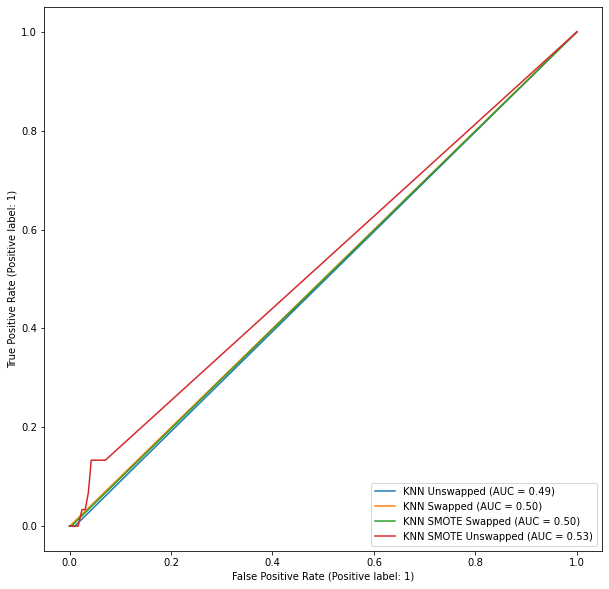

Wall time: 191 ms


In [22]:
fig, (ax1) = plt.subplots(1,figsize=(10,10))

%time KNN_unswap_roc = plot_roc_curve(knn_unswap, x_test, y_test, ax=ax1, name="KNN Unswapped")
%time KNN_swap_roc = plot_roc_curve(knn_swap, x_test, y_test, ax=ax1, name="KNN Swapped")
%time KNN_smote_swap_roc = plot_roc_curve(knn_smote_swap, x_test, y_test, ax=ax1, name="KNN SMOTE Swapped")
%time KNN_smote_unswap_roc = plot_roc_curve(knn_smote_unswap, x_test, y_test, ax=ax1, name="KNN SMOTE Unswapped")



%time plt.show()

With the KNN classifier, we see some very odd behavior, indicating that the KNN model was unable to make any meaningful discrimination between the two target values. The only model that had a slight performance boose was the unswapped SMOTE data. However, this ROC analysis indicates that the model is not properly tuned for this dataset, possibly due to the lack of feature scaling (which is not necessary for certain models, but is indeed necessary for KNN). I realized this too late to fix before the deadline.

Wall time: 5.04 s
Wall time: 4.29 s
Wall time: 4.75 s
Wall time: 4.76 s


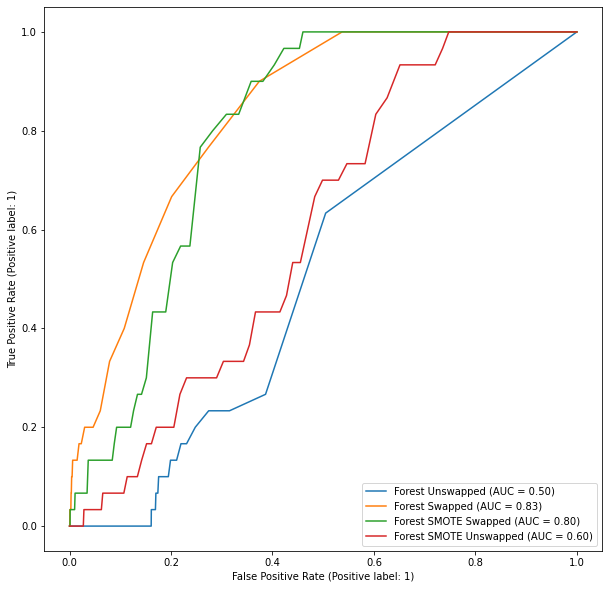

Wall time: 199 ms


In [23]:
fig, (ax1) = plt.subplots(1,figsize=(10,10))


%time forest_unswap_roc = plot_roc_curve(forest_unswap, x_test, y_test, ax=ax1, name="Forest Unswapped")
%time forest_swap_roc = plot_roc_curve(forest_swap, x_test, y_test, ax=ax1, name="Forest Swapped")
%time forest_smote_swap_roc = plot_roc_curve(forest_smote_swap, x_test, y_test, ax=ax1, name="Forest SMOTE Swapped")
%time forest_smote_unswap_roc = plot_roc_curve(forest_smote_unswap, x_test, y_test, ax=ax1, name="Forest SMOTE Unswapped")


%time plt.show()

### 3b. Analyse the performance of the classifiers. Explain which method performs best.

**It is important for me to note that the results of the ROC curve analysis changed at the last minute during my last "run through" of the notebook. There was no time to retrain the models before the deadline, so a lot of my analysis is based on what you see here in this version. I am not entirely sure (deadline approaching) why this is the case. The previous versions of this notebook had different ROC curves, where SMOTE data was moderately to significantly better across all models. Additionally, these previous versions also showed that the rank-swapped data performed slightly to moderately worse than unswapped data. The results weren't staggering, but they were notable.**

Of the three models, the "best" classifier is the Random Forest, of which the swapped, oversampled data (SMOTE) has the highest ROC score. Both the swapped, unswapped, and oversampled data all performed relatively similarly to each other. 

Next is the Stochastic Gradient Descent model, which has much poorer performance as described above. Finally, the K-nearest neighbors model performed poorly, both on swapped, unswapped, and oversampled data. The models were closely aligned with one another, but performed barely better than average (0.5 AUC). 

Across all three models, however, it is clear that oversampling the data has a positive effect.

One could potentially improve the models by performing k-fold cross validation, with the notable caveat that folding time-series data could potentially have a negative effect on the model if the timing of the fraudulent transactions were of particular consequence. However, it could just as easily be posited that due to the low correlation between timing and fraudulent transactions (see heat maps above), it is unlikely with this dataset that timing of the transactions is of notable consequence.

### 3c. Can you explain the performance difference for the different classifiers? Is it advisable to protect people’s privacy using rank-swapping? Why (not)?

In every single model tested, the unswapped data performed slightly worse than the swapped data, which is odd. This did not occur during the programming of this notebook, and only occurred at the end of the assignment, with ~1 hour until the deadline. Due to the training time involved, it was impossible for me to go back and figure out what was going on. In earlier iterations of this notebook, rank-swapped data performed slightly to significantly worse than unswapped data, across all models. 

**The following description below is based on previous results, where rank-swapped data was worse than unswapped data:**
The decision to protect people's privacy using rank-swapping is of course a subjective discussion, however one could argue that certain models are more resilient to rank-swapping than others, and therefore efforts *could* be made to protect user privacy using rank-swapping. That being said, based on this analysis it is undeniable that rank-swapping had an adverse effect on the predictive power of the models, and the model must be carefully chosen and tuned if rank-swapping is going to be implemented.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ad0f8f88-574f-4936-aedb-0b72571d8308' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>